## 인물모드 사진 만들기

### 학습 목표
- 딥러닝을 적용하여 핸드폰 인물 사진 모드를 따라 해보자.

### 루브릭 
- 인물모드 사진을 성공적으로 제작하였다. : **아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.**
- 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다. : **인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.**
- 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다. : **추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.**

## 목차
### 1. 시맨틱 세그멘테이션(Semantic segmentation)
### 2. 셸로우 포커스(Shallow focus)
### 3. 인물모드 사진 만들기
#### 1) 여러명의 인물(셸로우 포커스)
#### 2) 고양이(셸로우 포커스)
#### 3) 강아지 (크로마키 배경 합성)
### 4. 인물모드 사진의 문제점과 개선방안
---

## 1. 시맨틱 세그멘테이션(Semantic segmentation)
- 이미지에서 픽셀 단위로 관심 객체를 추출하여, 물리적 의미 단위로 같은 라벨을 붙여 분류하는 방법.
- '사람'이라는 추상적인 정보를 이미지에서 추출해 내는 방법으로, 사람 개개인별로 분류하지는 않는다.(개개인별로, 각 객체를 분할하여 인식한 후 다른 라벨을 가지게 하는 방법은 '인스턴스 세그멘테이션'이라고 한다.)

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

(1280, 960, 3)


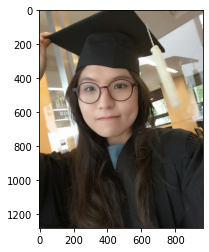

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f6b3996ba00>)

인물 사진을 준비하고 PixelLib에서 제공하는 모델을 다운로드 한다.

In [4]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [5]:
segvalues,output = model.segmentAsPascalvoc(img_path)

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

semantic segmentation 모델을 생성하고, PASCAL VOC 데이터로 이미지를 학습한다. PASCAL VOC 데이터에 존재하는 클래스를 'LABEL_NAMES' 리스트에 저장해둔다.('background'를 제외하면 총 20개의 개체 분리 가능)

(1280, 960, 3)


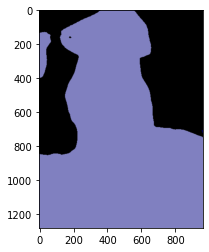

In [7]:
print(output.shape)
plt.imshow(output)
plt.show()

In [8]:
segvalues

{'class_ids': array([ 0,  9, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])}

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person


첫번째 이미지를 학습한 결과 output에는 세그멘테이션이 진행된 결과가 각각 다른 색상으로 담기고, segvalues에는 class_ids와 masks가 담긴다. class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있다. (0: background / 9: chair / 15: person 추출)

In [10]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
colormap[15]    # person

array([192, 128, 128])

In [12]:
seg_color = (128,128,192)

output 물체마다 어떤 색상으로 나타나있는지 colormap array에 나타낸다. 단, output 이미지는 BGR, colormap은 RGB 순서로 채널 배치가 되어 있으므로 추출하고자 하는 색상값 seg_color는 colormap을 참고하되 BGR 기준으로 순서를 바꾸어 저장해야 한다.

(1280, 960)


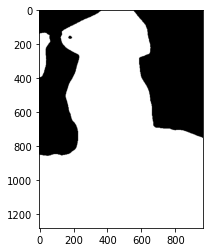

In [13]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

output의 픽셀 별로 seg_color와 같은 색상은 1(True), 다르다면 0(False)이 되게끔 지정한다.
* np.all(조건): 배열의 모든 데이터가 조건과 맞으면 True, 하나라도 다르면 False를 반환한다.
  * axis=-1: 현재 배열의 마지막 axis를 의미한다.

output은 (1280, 960, 3) shape의 3차원 배열이었으나, 마지막 axis인 채널에 np.all을 적용하여 모두 0 또는 1로 변환한 seg_map은 채널 정보가 사라져 단순히 물체가 있는 위치는 1, 없는 위치는 0이 저장된 (1280, 960) shape 2차원 배열이 된다.

In [14]:
seg_map.dtype

dtype('bool')

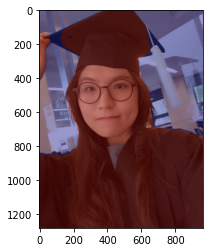

In [15]:
img_show = img_orig.copy()    # original 이미지 분리
img_mask = seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

세그맨테이션 결과를 확인하기 위해 seg_map을 원본 이미지와 겹쳐본다.

1. np.all()로 인해 'bool' dtype을 가지게 된 seg_map을 정수형으로 변경 후 그에 255를 곱하여 True(1)였던 곳은 하얀색, False(0)였던 곳은 검은색으로 지정한 회색조이미지 img_mask를 지정한다.
```python
img_show = img_orig.copy()    # original 이미지 분리
img_mask = seg_map.astype(np.uint8) * 255
```
  * asytpe(데이터형): Numpy의 데이터형인 dtype을 변경한다.
  
  
2. img_mask에 컬러맵(cv2.COLORMAP_JET)을 지정 후, 원본 이미지와 겹쳐보이도록 하여 세그멘테이션 결과를 확인한다.
```python
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
```
  * cv2.applyColorMap(src, colormap): 입력이미지(src)에 colormap을 결과 이미지를 반환한다.
  * cv2.addWeighted(imgA, a, imgB,b, c): 각 픽셀에 imgA * a + imgB * b + c 산술식을 적용한 이미지를 반환한다. 

## 2. 셸로우 포커스(Shallow focus)
* 초점이 맞은 피사체를 제외한 배경을 흐리게 만드는 기술.('인물 사진 모드')
* 세그맨테이션을 통해 피사체와 배경을 분리한 다음, 분리된 배경을 블러 처리 후 피사체를 원래 위치에 합성하여 구현한다.

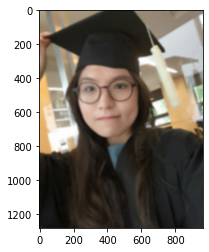

In [16]:
img_orig_blur = cv2.blur(img_orig, (13,13))   # blurring kernel size: 클 수록 더 흐려짐
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

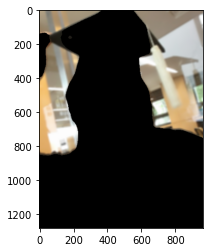

In [17]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

원본 이미지를 블러 처리한 img_orig_blur를 생성한 후, 이미지 비트연산을 통해 피사체의 위치를 지정한다.

1. 채널 정보 없이 인물은 흰색(255), 배경은 검은색(0)으로 나타내고 있는 2차원 shape 회색조이미지 img_mask에 BGR 채널을 지정한 img_mask_color를 생성한다.
```python
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
```

2. img_mask_color의 색을 반전시켜 배경을 흰색(255), 인물을 검은색(0)으로 변환시킨 후, img_orig_blur와의 and 연산을 통해 인물은 검은색으로, 배경은 블러 처리된 배경의 틀을 얻는다.
```python
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
```
* cv2.bitwise_not(): 비트연산에서는 색이 있으면 0, 색이 없으면 1이다. img_mask_color의 각 비트에 not 연산을 수행하여 0은 1로, 1은 0으로 변환한다.
* cv2.bitwise_and(): img_orig_blur와 img_bg_mask 각 비트에 and 연산을 수행한다. 둘 중 하나라도 0일 경우 0을 반환하므로 인물이 있는 지점은 모두 0이된다.

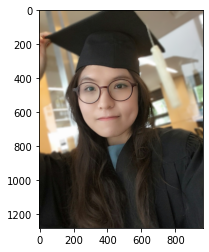

In [18]:
img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

피사체와 블러 처리된 배경을 합성하여 완성한다.
* np.where(조건, 참일 때, 거짓일 때): numpy.array로 이루어져있는 이미지를 합성할 때 주로 사용한다. 조건을 만족하는 픽셀에는 '참일 때'의 이미지를, 만족하지 않는 픽셀에는 '거짓일 때'의 이미지를 출력한다.

## 3. 인물모드 사진 만들기

In [19]:
def segmentation(img_path):
    LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ]
    SEG_NAMES = []
    
    segvalues,output = model.segmentAsPascalvoc(img_path)

    for class_id in segvalues['class_ids']:
        SEG_NAMES.append(LABEL_NAMES[class_id])
    
    return output, segvalues, SEG_NAMES

In [20]:
def shallow_focus(img_orig, img_mask):
    img_orig_blur = cv2.blur(img_orig, (13,13))  
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

    img_concat = np.where(img_mask_color == 255, img_orig, img_orig_blur)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

세그멘테이션과 셸로우 포커스 과정을 함수로 구현했다. segmentation(img_path)는 입력한 이미지를 학습한 결과인 (output, segvalues, SEG_NAMES)로 이루어진 튜플을 반환하여 이미지에 어떤 개체가 있는지 확인('class_ids')하도록 하였고, shallow_focue(img_orig, img_mask)는 세그멘테이션의 결과를 통해 사용자가 보고자 하는 개체를 골라 하얗게(True, 255) 처리한 img_mask를 이용하여, 입력한 이미지에서 블러 처리할 배경과 원본 그대로인 개체를 합성해 '인물사진' 모드 사진을 출력한다.

### 1) 여러명의 인물(셸로우 포커스)

(720, 1280, 3)


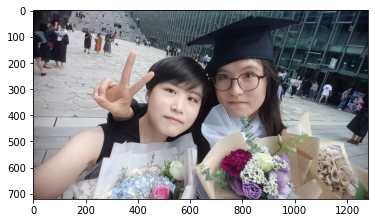

In [21]:
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image3.jpg'  
img_orig2 = cv2.imread(img_path2) 

print(img_orig2.shape)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.show()

In [22]:
segmentation(img_path2)[1]

{'class_ids': array([ 0, 11, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])}

In [23]:
segmentation(img_path2)[2]

['background', 'diningtable', 'person']

In [24]:
colormap[15]    # person

array([192, 128, 128])

In [25]:
seg_color = (128, 128, 192)

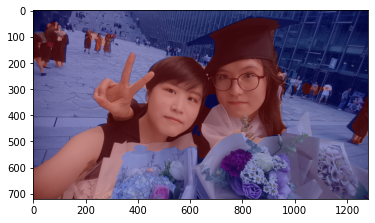

In [26]:
seg_map = np.all(segmentation(img_path2)[0]==seg_color, axis=-1)

img_show = img_orig2.copy()
img_mask = seg_map.astype(np.uint8) * 255
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

사진의 주인공들 뿐만 아니라 주변 사람들까지 똑같은 'person'으로 인식하고 있다.

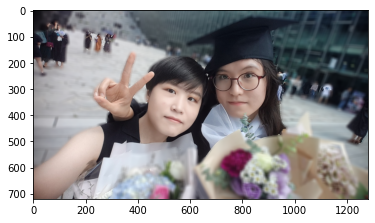

In [27]:
shallow_focus(img_orig2, img_mask)

### 2) 고양이 (셸로우 포커스)

(817, 1024, 3)


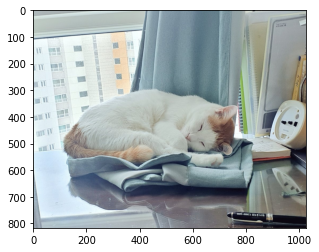

In [28]:
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/Oli.jpg'  
img_orig3 = cv2.imread(img_path3) 

print(img_orig3.shape)
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.show()

In [29]:
segmentation(img_path3)[1]

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [30]:
segmentation(img_path3)[2]

['background', 'cat']

In [31]:
colormap[8]    # cat

array([64,  0,  0])

In [32]:
seg_color = (0, 0, 64)

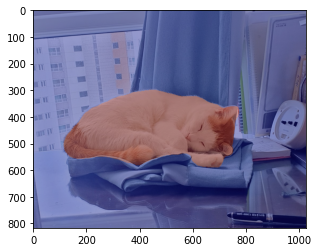

In [33]:
seg_map = np.all(segmentation(img_path3)[0]==seg_color, axis=-1)

img_show = img_orig3.copy()
img_mask = seg_map.astype(np.uint8) * 255
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

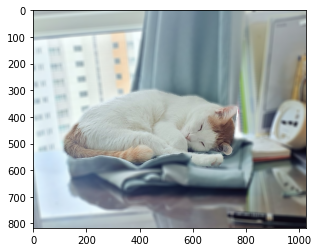

In [34]:
shallow_focus(img_orig3, img_mask)

### 3) 강아지 (크로마키 배경 합성)

(1920, 1920, 3)


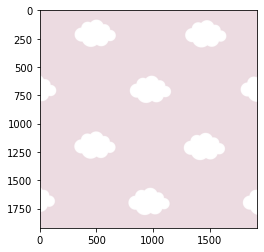

In [35]:
img_path_back = os.getenv('HOME')+'/aiffel/human_segmentation/images/background.png'  
img_back = cv2.imread(img_path_back) 

print(img_back.shape)
plt.imshow(cv2.cvtColor(img_back, cv2.COLOR_BGR2RGB))
plt.show()

(960, 1280, 3)


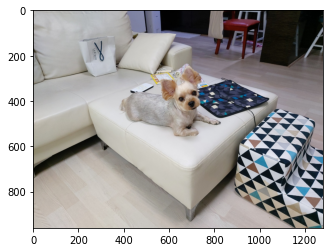

In [36]:
img_path4 = os.getenv('HOME')+'/aiffel/human_segmentation/images/Ddakjji.jpg'  
img_orig4 = cv2.imread(img_path4) 

print(img_orig4.shape)
plt.imshow(cv2.cvtColor(img_orig4, cv2.COLOR_BGR2RGB))
plt.show()

In [37]:
back_resize = cv2.resize(img_back, (1280, 1280))

배경 이미지가 강아지 사진에 비해 너무 크므로 기존 정사각형의 비율을 유지하되 크기는 강아지 사진의 가로 길이에 맞춰 줄였다.

(1280, 1280, 3)


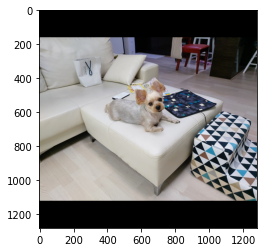

In [38]:
img_padding = cv2.copyMakeBorder(img_orig4, (1280-960)//2 ,(1280-960)//2, 0, 0, cv2.BORDER_CONSTANT, None, value = 0)
print(img_padding.shape)
plt.imshow(cv2.cvtColor(img_padding, cv2.COLOR_BGR2RGB))
plt.show()

In [39]:
cv2.imwrite(os.getenv('HOME')+'/aiffel/human_segmentation/images/Ddakjji_padding.jpg', img_padding)

True

배경 이미지와 강아지 사진을 합성하기에 앞서 두 사진의 크기를 똑같이 맞춰주기 위해 강아지 사진의 top, bottom에 '0'(검은색) 패딩을 입힌다음, 새 파일로 저장한다.
* cv2.copyMakeBorder(입력이미지, 위쪽, 아래쪽, 왼쪽, 오른쪽 - 경계의 폭 (해당 방향의 픽셀 수), borderType, (value))
  * borderType: 추가되는 경계의 종류를 정의하는 플래그. cv2.BORDER_CONSTANT는 일정한 색상의 테두리를 추가하는 플래그로, 값은 다음 인수 value로 제공되어야 한다.
  
코드 참조: [GeeksforGeeks](https://www.geeksforgeeks.org/python-opencv-cv2-copymakeborder-method/)

In [40]:
img_path5 = os.getenv('HOME')+'/aiffel/human_segmentation/images/Ddakjji_padding.jpg'  
img_orig5 = cv2.imread(img_path5) 

segmentation(img_path5)[1]

{'class_ids': array([ 0,  9, 12, 18]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [41]:
segmentation(img_path5)[2]

['background', 'chair', 'dog', 'sofa']

In [42]:
colormap[12]    # dog

array([ 64,   0, 128])

In [43]:
seg_color=(128, 0, 64)

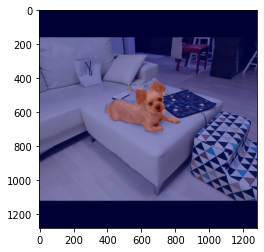

In [44]:
seg_map = np.all(segmentation(img_path5)[0]==seg_color, axis=-1)

img_show = img_orig5.copy()
img_mask = seg_map.astype(np.uint8) * 255
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

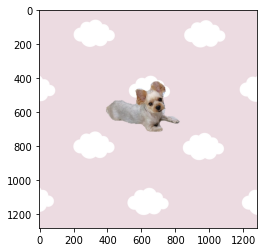

In [45]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_concat = np.where(img_mask_color == 255, img_orig5, back_resize)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

패딩을 입힌 강아지 사진에 세그맨테이션을 적용하여 강아지 개체를 구분한 다음, 크기를 조절한 배경 사진과 합성하여 완성한다.

## 4. 인물모드 사진의 문제점과 개선방안

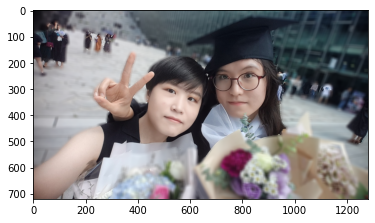

In [46]:
seg_color = (128, 128, 192)
seg_map = np.all(segmentation(img_path2)[0]==seg_color, axis=-1)
img_mask = seg_map.astype(np.uint8) * 255

img_orig_blur = cv2.blur(img_orig2, (13,13))  
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_concat = np.where(img_mask_color == 255, img_orig2, img_orig_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

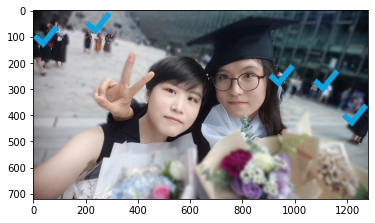

In [47]:
sticker_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/check.png'  
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (100,100))

wrong_area_1 = img_concat[50:150, 0:100]
wrong_area_2 = img_concat[0:100, 200:300]
wrong_area_3 = img_concat[200:300, 900:1000]
wrong_area_4 = img_concat[220:320, 1070:1170]
wrong_area_5 = img_concat[350:450, 1180:1280]

img_concat[50:150, 0:100] = np.where(img_sticker==255, wrong_area_1, img_sticker).astype(np.uint8)
img_concat[0:100, 200:300] = np.where(img_sticker==255, wrong_area_2, img_sticker).astype(np.uint8)
img_concat[200:300, 900:1000] = np.where(img_sticker==255, wrong_area_3, img_sticker).astype(np.uint8)
img_concat[220:320, 1070:1170] = np.where(img_sticker==255, wrong_area_4, img_sticker).astype(np.uint8)
img_concat[350:450, 1180:1280] = np.where(img_sticker==255, wrong_area_5, img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

앞서 만든 '여러 명이 등장하는 인물' 사진에서는 사진의 주인공 뿐만 아니라 주변의 행인들도 똑같은 'person'으로 라벨링되어, 촛점이 흩어져 어색한 사진이 된다. 또한 주인공과 배경의 구분이 어색하여 가장자리 부분에서 문제점이 발생하는 것을 확인할 수 있다.

In [48]:
segvalues,output = model.segmentAsPascalvoc(img_path2)

In [49]:
type(output)

numpy.ndarray

In [50]:
output.dtype

dtype('uint8')

In [51]:
output.shape

(720, 1280, 3)

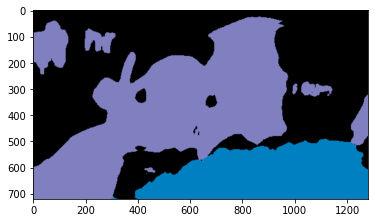

In [52]:
plt.imshow(output)
plt.show()

In [53]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
diningtable
person


In [54]:
print('\'background\' color = ',output[300][100])
print('\'diningtable\' color = ',output[700][700])
print('\'person\' color = ',output[400][400])

'background' color =  [0 0 0]
'diningtable' color =  [  0 128 192]
'person' color =  [128 128 192]


semantic segmentation 모델이 PASCAL VOC 데이터로 이미지를 학습한 결과인 'output'은 개체를 색으로 구분하여 저장하고 있는, 채널을 포함한 3차원 행렬이다.(RGB 채널) 단, 색으로 각 개체를 구분만 하고 있을 뿐 각각을 무엇으로 인식했는지 확인하기 위해서는 또다른 학습결과인 'segvalues'를 확인할 필요가 있다.

In [55]:
type(segvalues)

dict

In [56]:
segvalues.keys()

dict_keys(['class_ids', 'masks'])

In [57]:
segvalues['class_ids']

array([ 0, 11, 15])

In [58]:
segvalues['masks']

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [59]:
segvalues['masks'].dtype

dtype('bool')

In [60]:
segvalues['masks'].shape

(720, 1280)

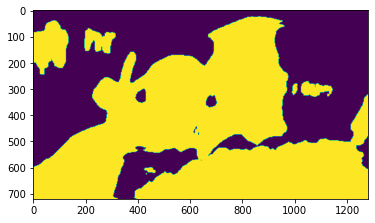

In [61]:
masks = segvalues['masks'].astype(np.uint8)    # bool 자료형을 unit8 정수 자료형으로 변경
plt.imshow(masks)
plt.show()

In [62]:
print('\'background\' = ',segvalues['masks'][300][100])
print('\'diningtable\' = ',segvalues['masks'][700][700])
print('\'person\' = ',segvalues['masks'][400][400])

'background' =  False
'diningtable' =  True
'person' =  True


또다른 학습 결과물인 'segvalues'는 딕셔너리 자료형이다. 'class_ids'에 이미지에 들어있는 개체들의 종류를 저장하고, 'masks'에는 이미지의 픽셀 별로 개체가 있는 픽셀을 True, background를 False 두가지로만 구분하여 저장하고 있다. 즉, segvalues['masks']는 데이터 타입 또한 'bool'을 갖는 2차원 행렬이다. 

세그멘테이션에서 나타나는 문제점은 크게 두가지이다.
1. 원하는 인물(사진의 주인공)이 아닌 주변 행인도 'background'가 아닌 'person'으로 인식되는 한 'True'로 반환된다는 점
2. 인식된 인물 또는 피사체의 경계면이 배경과 다소 불명확하게 구분되는 경우가 있다는 점

이 두가지 문제점을 해결하는 방법으로는 **segvalues['masks']에 '피사계 심도'(depth of field, DOF) 구분값을 저장한 차원을 추가하여 3차원 bool 행렬로 만드는 것**을 제안할 수 있다. 피사계 심도란 사진에서 초점이 맞은 것으로 인식되는 범위를 의미하는데, 사진을 찍을 당시의 설정된 피사계 심도 범위에 들어온 영역은 True, 벗어난 영역은 False를 저장한 차원을 추가하는 것이다. 즉, 위 이미지의 segvalues['masks'].shape는 (720, 1280, 2)가 된다.

각 픽셀을 개체로 인식되면서 피사계 심도에 들어온 영역 [True True], 개체로 인식되었으나 피사계 심도에 들어오지 않는 영역 [True False], 개체로 인식되지 않았지만 피사계 심도에 들어온 영역 [False True], 개체로 인식되지 않았고 피사계 심도에도 들어오지 않은 영역 [False False] 네 가지로 분류하여 and 연산을 통해 [True True]만을 세그맨테이션 결과물로 반환하도록 하면 1번 문제는 해결된다.

이 방법을 구현하기 위해서는 사진을 찍을 때부터 피사계 심도 범위, 즉 렌즈로부터 사물까지의 거리 정보를 사진에 저장해야 하므로 이 방법을 구현하기 위해서는 사진을 찍을 때 3D 이미지센서를 만드시 탑재하고 있어야 한다. 3D 이미지센서가 3D 이미지를 얻는 방식 중 하나인 '직접 비행시간'(Direct Time of Flight, D-ToF) 방식에 의하면, 펄스 레이저를 사물에 조사해 반사된 신호들이 센서에 도착하는 시간을 측정함으로써 물체까지의 거리를 탐지할 수 있는데, 이 방식을 이용하면 피사체의 경계면이 배경과 명확하게 구분되지 않는 2번 문제도 해결될 수 있다.

## 회고

- 문제 개선 방안으로 결국 지나치게 고비용을 요하는 하드웨어 개발 밖에 제시하지 못한 지점이 아쉽다. ~구글의 struct2Depth 사례...는 너무 어려워서 일단 패스~ '시멘틱 세그멘테이션' 외에 '인스턴스 세그멘테이션'을 사용해도 1번 문제를 해결할 수 있을 것 같은데, MS COCO 데이터셋처럼 인스턴스 세그멘테이션을 위한 데이터셋을 개발하는데에도 적지 않은 시간과 비용이 들 것을 고려하면 하드웨어 개발과 충분한 데이터셋 구성 둘 중 어느 쪽이 더 효율적일까 생각해보아야 할 것 같다. 딥러닝 분야 자체도 여러가지 방법론 보다도 하드웨어 기술 발전과 비용 절감에 더 큰 혁신을 이룰 수 있었다고 하는데 결국 하드웨어의 영향이 더 지대한 것 같으면서도....
- 사람이 세상을 3D로 인지하는 것은 시각만을 통해 얻은 정보라기보다는 자기 자신의 위치 정보, 위치 감각을 이용하는 것이기도 하다. 컴퓨터가 3D 인식을 위해 구현하는 방법 역시 신호가 반사되어 돌아오는 시간, 즉 거리 정보를 이용한다는 점에서 유사한데, 눈(렌즈) 앞에 있는 사물들의 방향으로, 일방향 신호를 보내는 것이 아니라 더 다양한 방향으로 보내야 실체를 3D로 인식할 수 있지 않을까.
- 피사계 심도 구분값을 추가할 수 있다면, 사진을 찍을 때 일일이 피사계 심도 범위(촛점)를 맞추기보다는 자동으로 맞춰주는 편의를 제공해야 할 것이다. 실제 사람의 시야는 배경은 블러 처리하고 보고자 하는 대상에만 촛점을 맞추는 방식으로 작동하지 않는다. 그렇다면 인물 사진을 구현할 때 어느 정도의 피사계 심도 범위를 제공해야 가장 '자연스러운' 인물 사진으로 보이게 될 지 궁금하다.